In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import os

## rating schema: 0 1 2 [3] 4 5 6

In [2]:
files = os.listdir("../export") # die ersten paar sind noch unique, dann wiederholt sich 47
base = "../export/"

# user ratings
dic_ratings = {}
for file in files:
    if ".pkl" in file and "160" in file and "ARTS" not in file:
        data = pd.read_pickle(base + file)
        df = pd.DataFrame(data).transpose()
        df.columns = ["matchup", "matchup_winner", "datetime", "choice"]
        df["datetime"] = df["datetime"].apply(lambda date: datetime.strptime(date, "%d/%m/%Y, %H:%M:%S"))
        df["choice"] = df["choice"].apply(lambda choice: tuple(choice)[0])
        dic_ratings[file.split(".")[0]] = df
        
# texts
texts = pd.read_pickle(base + "ARTS_only_texts_160.pkl")

# userprofiles (metadata)
userprofiles_tagged = pd.read_pickle(base + "userprofiles_tagged.pkl")

# user groups
user_group_map = pd.read_pickle(base + "user_group_map.pkl")

# group matchups
A = pd.read_pickle(base + "determined_pairs_640_A.pkl")
B = pd.read_pickle(base + "determined_pairs_640_B.pkl")
C = pd.read_pickle(base + "determined_pairs_640_C.pkl")

## 1. calculate average rating for each matchup


In [3]:
average_rating = {}
flipped_ratings = {0 : 6, 1 : 5, 2 : 4, 4 : 2, 5 : 1, 6: 0}
for rater in dic_ratings.values():
    for rating in rater.iterrows():
        index = rating[0]
        rating = rating[1]
        matchup = tuple(sorted(rating["matchup"])) # sorted matchup
        if matchup not in list(average_rating.keys()):
            average_rating[matchup] = {"decisions" : [], "ratings" : [], "time_diffs" : []}
        average_rating[matchup]["decisions"].append(rating["matchup_winner"])
        if rating[0][0] > rating[0][1]:
            flipped_rating = flipped_ratings[rating["choice"]]
            average_rating[matchup]["ratings"].append(flipped_rating)
        else:
            average_rating[matchup]["ratings"].append(rating["choice"])
        
        if index < 159:
            average_rating[matchup]["time_diffs"].append((rater.iloc[index+1]["datetime"] - rater.iloc[index]["datetime"]).total_seconds())
        
        
for matchup, data in average_rating.items():
    average_rating[matchup]["average_rating"] = np.array(average_rating[matchup]["ratings"]).mean()

### wir haben die ratings und decisions aller matchups für alle user gesammelt, und dann das durchschnittliche rating aller user für jedes match berechnet
<br>

### da manche matchups geflippt waren für manche user (z.b (1,2) war für jemand anderen (2,1)) haben wir dies berücksichtigt und diese zwei dennoch als das selbe match angesehen. die antworten dieser zwei matches sind also zusammen in den (1,2) durchschnitt eingeflossen. um die paare zu identifizeren haben wir immer die kleinere zahl im matchup nach links getan (aufsteigen sortiert) somit konnten alle matchpaare eindeutig zugeordnet werden.

In [4]:
average_rating

{(142, 145): {'decisions': [145, 145, 145, 145, 145, 145, 145, 145, 145, 145],
  'ratings': [6, 6, 6, 5, 6, 6, 5, 5, 6, 6],
  'time_diffs': [68.0, 83.0, 35.0, 87.0, 26.0, 185.0, 58.0, 53.0, 61.0, 109.0],
  'average_rating': 5.7},
 (10, 79): {'decisions': [10, 79, 79, 10, 79, 79, 10, 79, 79, 79],
  'ratings': [1, 5, 4, 2, 6, 5, 2, 6, 6, 4],
  'time_diffs': [11.0, 18.0, 20.0, 18.0, 7.0, 14.0, 24.0, 42.0, 61.0, 7.0],
  'average_rating': 4.1},
 (5, 23): {'decisions': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
  'ratings': [1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
  'time_diffs': [15.0, 17.0, 44.0, 89.0, 15.0, 21.0, 62.0, 47.0, 77.0, 112.0],
  'average_rating': 0.3},
 (38, 42): {'decisions': [38, 42, 38, 38, 42, 42, 42, 38, 42, 38],
  'ratings': [1, 4, 2, 2, 6, 4, 5, 1, 5, 2],
  'time_diffs': [11.0, 21.0, 18.0, 73.0, 26.0, 28.0, 28.0, 36.0, 39.0, 13.0],
  'average_rating': 3.2},
 (89, 119): {'decisions': [89, 119, 89, 89, 89, 89, 89, 119, 89, 89],
  'ratings': [2, 6, 0, 2, 2, 1, 2, 5, 1, 0],
  'time_diffs': [17

### wir erstellen ein simplicity ranking um den rest der analyse fortsetzen zu können.

In [5]:
simplicity_rating = pd.DataFrame({"text" : texts["Text_formatted"].copy(), "text_n" : np.arange(0, 160), "simplicity" : np.zeros(160)})

In [6]:
simplicity_rating

,text,text_n,simplicity
0,"It was a small and disorganized depression, an...",0,0.0
1,According to an early review by website iFixIt...,1,0.0
2,The Federal Deposit Insurance Corporation (FDI...,2,0.0
3,"The filling has mashed sweet potatoes, milk, s...",3,0.0
4,"Born in 1951, Lightning Bar was bred to be a r...",4,0.0
...,...,...,...
155,To the north is Lisbon's central commercial di...,155,0.0
156,Some of its streets are so steep that they giv...,156,0.0
157,"Although progress was slow, efforts were under...",157,0.0
158,"After the war, the city was returned to the Du...",158,0.0


In [7]:
for matchup, data in average_rating.items():
    if data["average_rating"] > 3: # rating > 3 rechter text ist simpler und hat gewonnen
        simplicity_rating.loc[matchup[0], "simplicity"] += abs(data["average_rating"] - 3) # linker text wird aufaddiert, score geht hoch (komplexer)
        simplicity_rating.loc[matchup[1], "simplicity"] -= abs(data["average_rating"] - 3) # rechter text wird subtrahiert, score geht runter (einfacher)
    elif data["average_rating"] < 3: # rating < 3 = linker text ist simpler und hat gewonnen
        simplicity_rating.loc[matchup[0], "simplicity"] -= abs(data["average_rating"] - 3) # linker text wird subtrahiert, score geht runter (einfacher)
        simplicity_rating.loc[matchup[1], "simplicity"] += abs(data["average_rating"] - 3) # rechter text wird aufaddiert, score geht hoch (komplexer)

# zwichen 0-1 normalisieren
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform([[x] for x in simplicity_rating["simplicity"]])
simplicity_rating["simplicity"] = scaled.flatten()
simplicity_rating = simplicity_rating.sort_values("simplicity", ascending = False).reset_index(drop = True)

### simplicity rating für jeden text wird erstellt indem die durchschnittliche bewertung jedes matchups vom gewinner subtrahiert wird, und dem verlierer aufaddiert wird. somit haben die, die viele matches gewinnen ein niedriges rating (simplerere texte), und die die viele matches verlieren ein höheres rating (komplexere texte).

In [8]:
simplicity_rating

,text,text_n,simplicity,text_len,text_len_normalized
0,"A mycorrhiza (Gk.,: fungus roots, pl mycorrhiz...",23,1.000000,202,0.750000
1,"If he displeases us, we may express our distas...",101,0.967914,205,0.763393
2,Algae lack the various structures that charact...,33,0.967914,213,0.799107
3,"There have certainly been, even in our own tim...",87,0.914439,175,0.629464
4,Its ideal of character is to be without any no...,92,0.909091,258,1.000000
...,...,...,...,...,...
155,"The filling has mashed sweet potatoes, milk, s...",3,0.090909,73,0.174107
156,"After the war, the city was returned to the Du...",158,0.058824,51,0.075893
157,Many of Lisbon's residents became rich.\n,145,0.037433,40,0.026786
158,Movies are also made in the city.\n,153,0.029412,34,0.000000


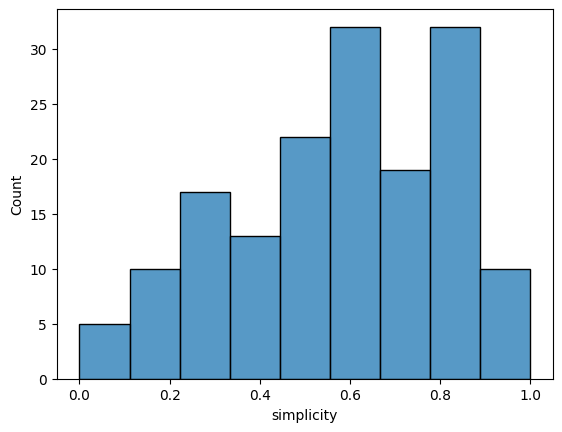

In [9]:
sns.histplot(data = simplicity_rating["simplicity"])
plt.show()

In [ ]:
# vlt zu den sachen die wir sowieso machen wollten noch zusätzlich:
# statistisch feststellen was einen text einfach macht... (anzahl wörter, länge wörter, länge text(zeichen))
# extreme werte zu antwortzeit, simplicity, textlänge, etc.

# FRAGEN:
- was war nochmal mit User Group Nap
<br>
<br>
<br>
- 81 Part anschauen ob es Effekte auf die 
-	Antwort Dauer 
<br>
<br>
- Bei welchen Texten brauchten die rater am längsten.
Einzelne Ausreißer anschauen
<br>
- Die Antwortdauer über den zeitraum + mit den 3 A B C

<br>

- extremheit der menschen, mehr links/rechts, oder eher mitte?
- geht extremheit im laufe der befragung rauf oder runter?
- extremheit zu antwortdauer

In [30]:
# Korrelation zu Englisch Level
# Korrelation zu Alter

# brauchen die leute jetzt länger zu beantworten als in der vorherigen arts befragung wegen multiple choice / skalenbewertung

# ANALYSE Unserer Punkte

In [104]:
def score_differenz_antwortzeit():
    score_diffs = []
    average_times = []
    for key, value in average_rating.items():
        left_score = simplicity_rating[simplicity_rating["text_n"] == key[0]]["simplicity"].iloc[0]
        right_score = simplicity_rating[simplicity_rating["text_n"] == key[1]]["simplicity"].iloc[0]
        score_diffs.append(abs(left_score - right_score))
        average_times.append(np.median(np.array(value["time_diffs"])))
    sns.regplot(x = average_times, y = score_diffs)
    plt.show()
    print("Korrelation zwischen Differenz der Schwierigkeit in einem match/Antwortzeit:", round(pd.Series(score_diffs).corr(pd.Series(average_times)), 3))
    
def textlaenge_einfachheit():
    text_len = simplicity_rating["text"].apply(lambda x: len(x))
    text_len_normalized = (text_len-min(text_len))/(max(text_len)-min(text_len))
    sns.regplot(x = simplicity_rating["simplicity"], y = simplicity_rating["text_len_normalized"])
    plt.show()
    print("Korrelation zwischen textlänge/einfachheit:", round(text_len_normalized.corr(simplicity_rating["simplicity"]), 3))

def antwortzeit_im_laufe_der_befragung(rolling_mean):
    diffs = np.zeros(640 * len(dic_ratings)).reshape(640, len(dic_ratings))
    medians = np.zeros(640)
    for i, value in enumerate(dic_ratings.values()):
        diffs[:, i] += (value["datetime"].shift(-1) - value["datetime"]).apply(lambda diff: diff.total_seconds())
    for i in range(0, len(medians)):
        medians[i] = np.median(diffs[i, :])
    if rolling_mean:
        sns.lineplot(data = pd.Series(medians[:-1]).rolling(10).mean())
    else:
        sns.lineplot(data = medians[:-1])
    plt.show()

def durschnittliche_wortlaenge_einfachheit():
    words = simplicity_rating["text"].apply(lambda text: text.replace(",", "").replace(".", "").replace("(", "").replace(")", "").replace(":", "").split(" "))
    avg_word_len = words.apply(lambda x: np.array([len(word) for word in x]).mean())
    sns.regplot(x = avg_word_len, y = simplicity_rating["simplicity"])
    plt.show()
    print("Korrelation zwischen Durchschnittliche Wortlänge/einfachheit:", round(avg_word_len.corr(simplicity_rating["simplicity"]), 3))

def antwortzeit_tageszeit():
    date = []
    timediff = []
    for value in dic_ratings.values():
        for i in range(0, len(value.index)):
            seconds_since_day = (value.iloc[i]["datetime"].hour * 60 * 60) + (value.iloc[i]["datetime"].minute * 60) + value.iloc[i]["datetime"].second
            day_time_normalized = (seconds_since_day / (24 * 60 * 60)) * 24
            if value.iloc[i]["time_diff"] < 300:
                date.append(day_time_normalized)
                timediff.append(value.iloc[i]["time_diff"])
    sns.scatterplot(x = date, y = timediff)
    plt.show()
    
    

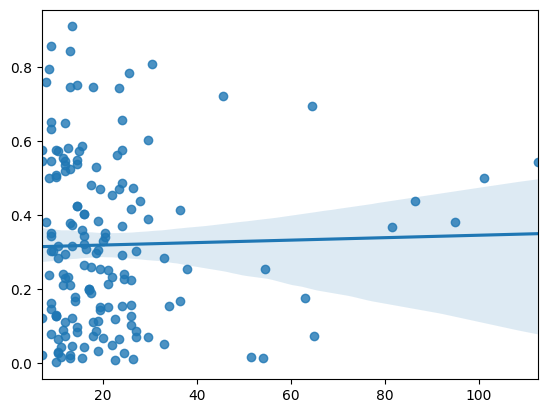

Korrelation zwischen Differenz der Schwierigkeit in einem match/Antwortzeit: 0.025


In [60]:
score_differenz_antwortzeit()

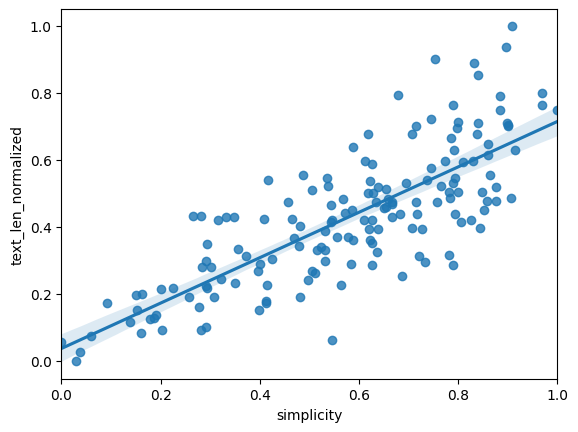

Korrelation zwischen textlänge/einfachheit: 0.787


In [57]:
textlaenge_einfachheit()

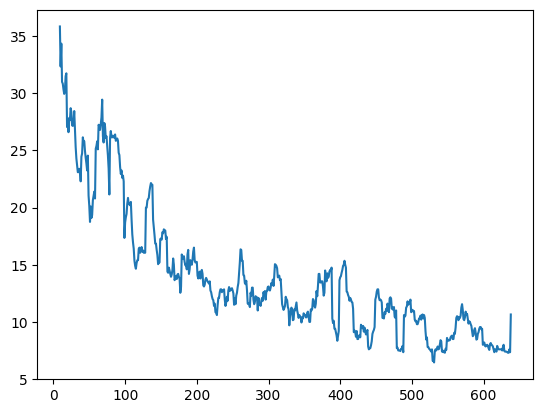

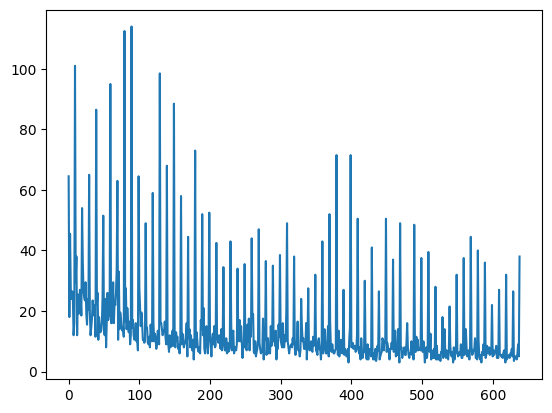

In [79]:
antwortzeit_im_laufe_der_befragung(rolling_mean = True)
antwortzeit_im_laufe_der_befragung(rolling_mean = False)

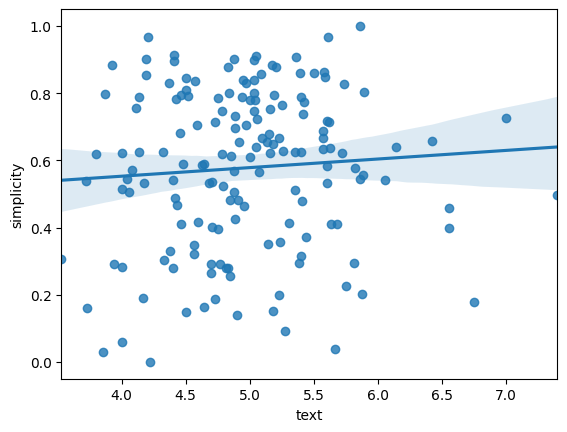

Korrelation zwischen Durchschnittliche Wortlänge/einfachheit: 0.072


In [89]:
durschnittliche_wortlaenge_einfachheit()

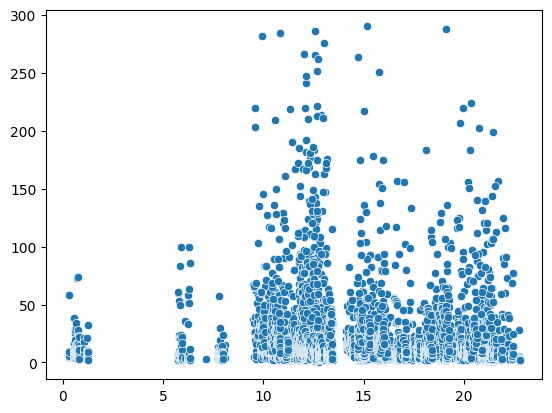

In [106]:
antwortzeit_tageszeit()